# Covid en Colombia

<img src="img/img_covid.png" width= 200>

> Imagen tomada de: https://www.paho.org/es/noticias/25-3-2020-similitudes-diferencias-entre-covid-19-gripe

La pandemia generada por el Covid-19 ha cruzado todos los continentes. Hasta la fecha (inicios de Diciembre 2020) ha infectado de 64.7 millones de personas y ha probocado aproximadamente 1.5 millones de muertes.

En este trabajo nos adentraremos en los datos de covid que expone de manera oficial el gobierno de Colombia, con el objetivo de encontrar patrones en su dinámica.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

import plotly.express as px # para pintar los mapas de las regiones
import json
from sklearn.metrics import roc_auc_score

## Carga de datos

In [92]:
# Cargar los datos
data_path = os.path.join("data", "bd_covid_colombia_1127.csv")
bd = pd.read_csv(data_path)

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (14,17,19,20,22) have mixed types. Specify dtype option on import or set low_memory=False.



## Descripción de los datos
Empecemos con una descripción general de los datos con los que trabajaremos

### Origen de los datos

Los datos principales que usaremos fueron tomados de la página:  
https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data



<img src="img/img_datos_abiertos.png">

Esta página pertenece a una entidad gubertamental de Colombia y provee de datos y estadísticas de libre consulta

In [93]:
# Una primera mirada a la tabla
display(bd.head())

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,...,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1.0,F,...,380.0,ITALIA,Recuperado,27/2/2020 0:00:00,NaN,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6.0,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1.0,M,...,724.0,ESPAÑA,Recuperado,4/3/2020 0:00:00,NaN,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5.0,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1.0,F,...,724.0,ESPAÑA,Recuperado,29/2/2020 0:00:00,NaN,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6.0,NaN
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1.0,M,...,NaN,NaN,Recuperado,6/3/2020 0:00:00,NaN,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6.0,NaN
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1.0,M,...,NaN,NaN,Recuperado,8/3/2020 0:00:00,NaN,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6.0,NaN


In [94]:
total_filas_bd, total_columnas_bd = bd.shape
print(f"La base de datos cuenta con {total_filas_bd} filas y {total_columnas_bd} columnas")

La base de datos cuenta con 1280487 filas y 23 columnas


### tipos de datos
Miremos qué tipos de datos tenemos en el dataframe

In [95]:
tipos_datos_df = pd.DataFrame(bd.dtypes, columns=[ "tipo_dato"])
tipos_datos_df.reset_index(inplace=True)
tipos_datos_df.rename(columns={"index":"campo"}, inplace=True)
tipos_datos_df

,campo,tipo_dato
0,fecha reporte web,object
1,ID de caso,int64
2,Fecha de notificación,object
3,Código DIVIPOLA departamento,int64
4,Nombre departamento,object
5,Código DIVIPOLA municipio,int64
6,Nombre municipio,object
7,Edad,int64
8,Unidad de medida de edad,float64
9,Sexo,object


In [96]:
tipos_datos_df.tipo_dato.value_counts()

object     16
int64       4
float64     3
Name: tipo_dato, dtype: int64

Contamos con un total de:  
* 7 columnas numéricas
* 6 columnas de fechas
* 16 columnas categóricas o strings

### descripción de los campos que usaremos
El enfoque de este trabajo estará centrado en los siguientes campos

Nombre de la variable | Valores | Categorías | Explicación
-- | -- | -- | -- 
__Fecha de reporte web__ | FECHA: DD/MM/AAA |  
__ID de caso__ | Número |  
__Códico DIVIPOLA departamento__ | Texto | -- | ejemplo: 13001 – Cartagena D.T. y C.
__Nombre departamento__ | Texto
__Edad__ | Número
__Sexo__ | Texto | F: Femenino M:Masculino
__Tipo de contagio__ | Texto | Relacionado, Importado, En estudio
__Estado__ | Texto | leve, moderado, grave, fallecido N/A
__Fecha de muerte__ | FECHA: DD/MM/AAA | -- | Fecha declarada del fallecimiento

## Preprocesamiento inicial de los datos
En esta sección se realizarán modificaciones al dataframe original con la intención de corregir errores en los datos o dar formato a estos para poder llevar a cabo los análisis posteriores

### Convertir las columnas de fecha a datetime

La base de datos tiene algunas columnas de fecha.  
Por este motivo se deben preprocesar estas columnas y convertirlas en tipo datetime de pandas

In [97]:
# Encontraremos todas las columnas con fechas
fechas_cols = [x for x in bd.columns if "fecha" in x.lower()]
fechas_cols

['fecha reporte web',
 'Fecha de notificación',
 'Fecha de inicio de síntomas',
 'Fecha de muerte',
 'Fecha de diagnóstico',
 'Fecha de recuperación']

In [98]:
# Convertimos cada columna de fecha en tipo datetime. 
# NOTA: Esta sección puede tardar un par de minutos
for fecha_col in fechas_cols:
    print(f"convirtiendo  en datetime la columna: '{fecha_col}'")    
    bd[fecha_col] = pd.to_datetime(bd[fecha_col], format="%d/%m/%Y %H:%M:%S", errors="coerce")

convirtiendo  en datetime la columna: 'fecha reporte web'
convirtiendo  en datetime la columna: 'Fecha de notificación'
convirtiendo  en datetime la columna: 'Fecha de inicio de síntomas'
convirtiendo  en datetime la columna: 'Fecha de muerte'
convirtiendo  en datetime la columna: 'Fecha de diagnóstico'
convirtiendo  en datetime la columna: 'Fecha de recuperación'


### Limitar la data a cierta fecha

Dado que la data sobre casos covid es muy dinámica, se puede dar que los datos presentados para los días recientes, varíen en el tiempo y estén incompletos. 

Por este motivo, limitaré los datos a los que ya tienen por lo menos 15 días de evolución, para garantizar que la información sea lo más completa posible en todas sus variables

In [99]:
dias_a_borrar = 15

fecha_max_data = bd["Fecha de notificación"].max() # máxima fecha presente en los datos
fecha_max_permitida =  fecha_max_data-datetime.timedelta(days=dias_a_borrar) # máxima fecha que se tendrá en los siguientes análisis
fecha_max_permitida

Timestamp('2020-11-11 00:00:00')

In [100]:
bd = bd[bd["Fecha de notificación"] <= fecha_max_permitida]
bd.shape

(1221170, 23)

### Corregir el código de departamento
el campo: "Código DIVIPOLA departamento" es un código asignado a cada departamento de Colombia.  
Este campo será necesario para pintar los futuros mapas, así que se corregirán los que tienen un sólo dígito para que empiecen por 0, de forma que crucen con la información geográfica.

In [101]:
def corregir_dptos(dpto):
    dpto_str = str(dpto)
    if len(dpto_str) == 1:
        return "0"+dpto_str
    else:
        return dpto_str

bd["Código DIVIPOLA departamento"]= bd["Código DIVIPOLA departamento"].apply(corregir_dptos)

### Corregir el código del departamento de Cesar
En la base de datos el código divipola del departamento de Cesar debe ser 20. Pero hay una entrada con un error, pues presenta otro código. 

In [102]:
mask = (bd["Nombre departamento"]=="CESAR") & (bd["Código DIVIPOLA departamento"]!="20")
bd.loc[mask, "Código DIVIPOLA departamento"]="20"

### Crear grupo etario
El campo "Edad" contiene un amplio rango de valores. La idea es crear una columna que contenga información de la edad pero agrupada.

In [103]:
bins = [bd["Edad"].min(), 10, 20, 30, 40, 50, 60, 70, bd["Edad"].max()] # grupos entre el mínimo de edad y el máximo de edad
grupos_etarios = pd.cut(bd["Edad"],bins)
grupos_etarios.value_counts()

(20, 30]     283483
(30, 40]     279635
(40, 50]     192054
(50, 60]     158495
(60, 70]      92131
(10, 20]      91580
(70, 110]     78710
(1, 10]       40358
Name: Edad, dtype: int64

In [104]:
bd["grupo_etario"] = grupos_etarios
# bd.head()

### Homologar los estados:
La base de datos trabaja con 4 tipos de estado para cada paciente: leve, moderado, grave, fallecido. Pero se puede encontrar que en ocasiones no hay una homologación en cómo escribir cada estado. Este puede venir en mayúsculas o minúsculas, siendo el mismo estado

In [105]:
bd["Estado"].value_counts()

Leve         1157494
Fallecido      35494
Moderado       21648
Grave           2468
moderado           1
Name: Estado, dtype: int64

In [106]:
def to_lower(x):
    if not pd.isna(x):
        return x.lower()
    else:
        return x
bd["Estado"] = bd["Estado"].apply(to_lower)
bd["Estado"].value_counts()

leve         1157494
fallecido      35494
moderado       21649
grave           2468
Name: Estado, dtype: int64

### Homologar el tipo de contagio
La variable "Tipo de contagio" habla sobre la forma como se contagió la persona. Sirve para identificar si el caso fue  
* importado (contagio por contacto con persona que viajó de otro país o se contagió en otro país)
* Relacionado: si el contagio se dio de manera local.  
Esta variable tiene un problema y es que no vienen homologadas las entradas, es decir: la misma categoría puede venir escrita de formas distintas

In [107]:
bd["Tipo de contagio"].unique()

array(['Importado', 'Relacionado', 'En estudio', 'relacionado',
       'RELACIONADO', 'En Estudio', 'EN ESTUDIO'], dtype=object)

In [108]:
bd["Tipo de contagio"] = bd["Tipo de contagio"].apply(lambda x: x.lower())
bd["Tipo de contagio"].unique()

array(['importado', 'relacionado', 'en estudio'], dtype=object)

## Evolución casos covid Colombia

En esta sección analizaremos cómo han evolucionado el número de infecciones en colombia en el tiempo. 
También la distribución de estos casos por tipo de contagio, sexo y por región geográfica

### Tipo de contagio
Esta variable era relevante al principio de la pandemia pues permitía saber en qué fase de transmisión se encontraba el país. 

Posibles fases:
* Transmisión importada: Fase donde los nuevos casos se dan por contacto entre personas del país con personas que vienen infectadas del exterior.
* Transmisión local: Fase en donde los nuevos casos se dan por contacto entre personas de la región. 

In [109]:
bd["Tipo de contagio"].value_counts(normalize=True).reset_index()

,index,Tipo de contagio
0,en estudio,0.900235
1,relacionado,0.099015
2,importado,0.000750


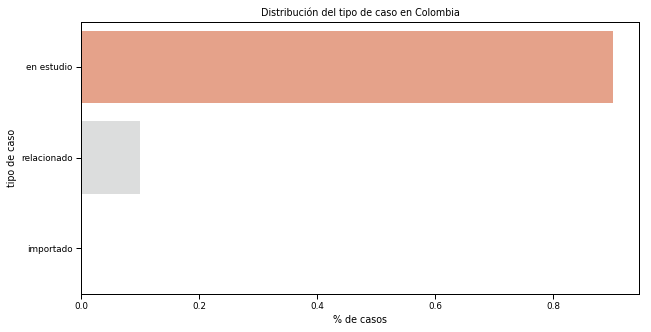

In [110]:
# gráfico de barras
plt.figure(figsize=(10, 5))
sns.set_context('paper')
sns.barplot(x="Tipo de contagio",y="index", data=bd["Tipo de contagio"].value_counts(normalize=True).reset_index(), palette="coolwarm_r")
plt.title("Distribución del tipo de caso en Colombia")
plt.xlabel("% de casos")
plt.ylabel("tipo de caso")
plt.show()

Esta variable era muy relevante al principio de la pandemia pues las administraciones locales decidían medidas de restricción de movibilidad según su medición.

Pero su relevancia no duró mucho, pues rápidamente pasamos a fase de _Transmisiones Locales_ por lo cuál el campo dejó de ser importante y las entidades que reportan los nuevos casos dejaron de proveer esta información.

Por este motivo esta variable no se usará en análisis posteriores

### Número de infecciones reportadas por día

Miremos el número de casos covid reportados por día desde el inicio de la pandemia en Colombia

In [111]:
# Agrupamos por fecha y se crea un nuevo dataframe con esta agrupación
casos_diarios = bd.groupby("Fecha de notificación")["ID de caso"].count().reset_index()
casos_diarios = casos_diarios.rename(columns={"ID de caso":"cuenta_casos"}) # renombro columnas

In [112]:
window = 14 # tamaño de la ventana para la media móvil
casos_diarios[f'media_movil'] = casos_diarios.cuenta_casos.rolling(window, min_periods=1).mean()

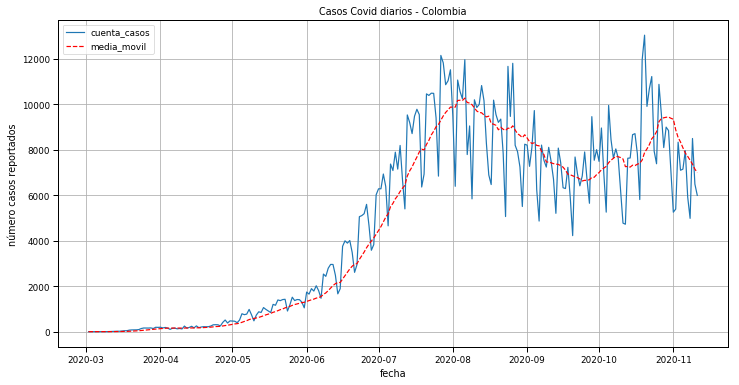

In [113]:
plt.figure(figsize=(12, 6))
plt.plot(casos_diarios["Fecha de notificación"], casos_diarios["cuenta_casos"])
plt.plot(casos_diarios["Fecha de notificación"], casos_diarios["media_movil"], "--", c="red")
plt.title("Casos Covid diarios - Colombia")
plt.xlabel("fecha")
plt.ylabel("número casos reportados")
plt.legend()
plt.grid()
plt.show()

In [114]:
# ¿dónde se dio el máximo de casos diarios?
casos_diarios[casos_diarios["cuenta_casos"]==casos_diarios["cuenta_casos"].max()]

,Fecha de notificación,cuenta_casos,media_movil
229,2020-10-20,13036,7874.357143


Como se puede observar en la gráfica anterior, Colombia parece haberse visto afectada por 2 olas de la infección.  
La primera ola tuvo su máximo a finales de Julio.  
La segunda ola parece haber tenido su máximo en el segundo tercio de Octubre

El pico máximo de casos diarios reportados en colombia se dio el 20 de Octubre, con un valor de 13036 casos

### Distribución geográfica de los casos

Colombia es un país que cuenta con una gran diversidad geográfica, natural y cultural.  
Esto quiere decir que se puede encontrar desde desiertos, hasta nevados,  Temperaturas altas y bajas, climas áridos y húmedos; sabana, bosque, 2 océanos, y la lista puede continuar. 

Así mismo, las culturas de las distintas regiones pueden diferir mucho entre ellas. Esto implica que las poblaciones responden de manera distinta a las medidas contra el covid, ya sea por su comportamiento y adopción cultural o por motivos como sus actividades económicas y exposición al virus.

In [115]:
dpto_data = bd.groupby(["Código DIVIPOLA departamento", "Nombre departamento"])["ID de caso"].count().reset_index()
dpto_data = dpto_data.rename(columns={"ID de caso":"cuenta_casos"})
dpto_data.head()

,Código DIVIPOLA departamento,Nombre departamento,cuenta_casos
0,05,ANTIOQUIA,197994
1,08,ATLANTICO,32108
2,11,BOGOTA,347316
3,13,BOLIVAR,7005
4,13001,CARTAGENA,28935


In [116]:
# se lee el archivo geojson con la información necesaria para pintar las distintas regiones de colombia
with open("data/dpto.geojson") as f:
    geodata_dpto = json.load(f)

In [117]:
# gráfica del mapa de colombia, dando un color de acuerdo al número de casos totales por departamento
fig = px.choropleth(
        dpto_data,
        locations='Código DIVIPOLA departamento',
        geojson=geodata_dpto,
        featureidkey="properties.DPTO_CCDGO",
        projection='mercator',
        color='cuenta_casos',
        color_continuous_scale= ["#B2F121", "red"],
        hover_data=['Nombre departamento', 'cuenta_casos'],
        height=500
        )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

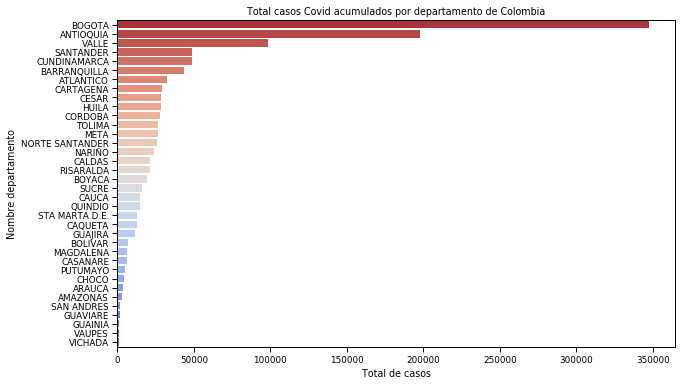

In [118]:
# gráfico de barras
plt.figure(figsize=(10, 6))
sns.set_context('paper')
sns.barplot(x="cuenta_casos",y="Nombre departamento", data=dpto_data.sort_values(by="cuenta_casos", ascending=False), palette="coolwarm_r")
plt.title("Total casos Covid acumulados por departamento de Colombia")
plt.xlabel("Total de casos")
plt.show()

El mayor número de casos detectados se concentra en los departamentos principales del país

**Aclaración:** En realidad Bogotá es un municipio que está dentro del departamento de cundinamarca, pero en los datos del gobierno se trata como departamento debido a que tiene las atribuciones administrativas que la ley confiere a los departamentos

Las ciudades principales de colombia son:
* **Bogotá**: que perteneec al departamento de **Cundinamarca**
* **Medellín**: que pertenece al departamento de **Antioquia**
* **Cali**: que pertenece al departamento del **Valle**

Cabe resaltar que justo los departamentos más afectados en número neto de casos covid, son los que contienen a las 3 ciudades principales del país.

### Distribución de los casos por género

Es interesante comprobar si la enfermedad ha atacado a las personas de ambos sexos por igual, o si tiene predilección por infectar un sexo en particular

In [119]:
bd["Sexo"].value_counts(normalize=True)

M    0.500105
F    0.499895
Name: Sexo, dtype: float64

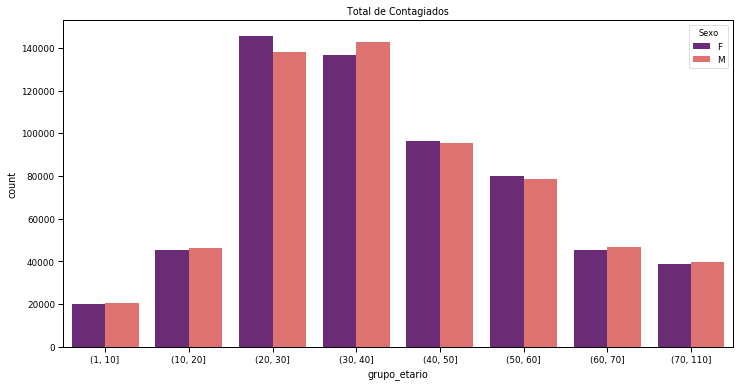

In [120]:
plt.figure(figsize=(12, 6))
sns.countplot(x = 'grupo_etario', hue = 'Sexo', data = bd, palette='magma')
plt.title('Total de Contagiados')

plt.show()

La relación entre hombres y mujeres que se han contagiado de la enfermedad es aproximadamente 50%-50%, indicando que en general, el virus no tiene una predilección por ninguno de los dos sexos. 

Para validar esta hipótesis, vemos que incluso por grupo etario, la relación 50%-50% se mantiene.

Lo que sí es un hallazgo interesante, es el hecho de que en general se contagian más personas entre los 20 y 40 años, que el resto de población. Siendo la población entre 1 y 10 los que menos casos presentan. 

#### Distribución de los casos por estado:
Miremos en términos generales, cómo es la distribución del estado de síntomas que presenta la enfermedad

In [121]:
bd["Estado"].value_counts(normalize=True)

leve         0.951022
fallecido    0.029163
moderado     0.017787
grave        0.002028
Name: Estado, dtype: float64

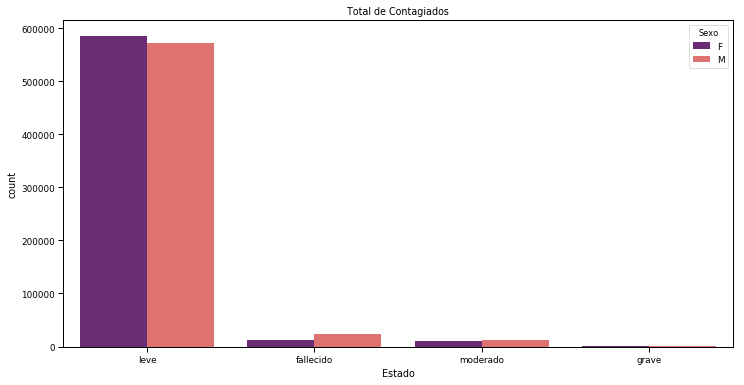

In [122]:
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Estado', hue = 'Sexo', data = bd, palette='magma')
plt.title('Total de Contagiados')
plt.show()

La gráfica anterior permite observar la dimensión de en qué evolucionan los casos covid.  
* El 95% de los casos termina siendo leve
* El 3% de los casos terminó en fallecimiento
* El 1.7% tuvo síntomas moderados
* El 0.2% tuvo síntomas graves

Esta información es muy útil, pero sería interesante ver si dentro de cada grupo de Estado, se diferencian los hombres de las mujeres.

Verifiquemos si hay un sexo predominante para cada tipo de Estado

In [123]:
# Se agrupa la data
estado_data = bd.groupby(["Estado", "Sexo"])["ID de caso"].count()
# display(estado_data)

# Se calculan los porcentajes de participación del sexo por tipo de estado
estado_data_pct = estado_data.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
display(estado_data_pct)

,Estado,Sexo,ID de caso
0,fallecido,F,0.358511
1,fallecido,M,0.641489
2,grave,F,0.368720
3,grave,M,0.631280
4,leve,F,0.505852
5,leve,M,0.494148
6,moderado,F,0.441129
7,moderado,M,0.558871


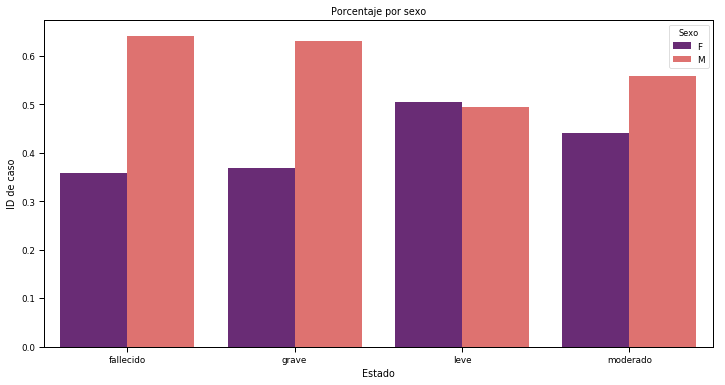

In [124]:
plt.figure(figsize=(12, 6))
sns.barplot(x = 'Estado', hue = 'Sexo',y="ID de caso", data = estado_data_pct, palette="magma")
plt.title('Porcentaje por sexo')

plt.show()

En la gráfica anterior sí es evidente cómo para los grupos de Estado: fallecido, grave y moderado; los hombres sí están más presentes en la estadística.  
Esto indica que los hombres tienden a complicarse por covid más que las mujeres.


## Análisis de las muertes por covid en Colombia

La enfermedad producida por covid puede tener un desenlace fatal.  
En el caso colombiano, observamos que aproximadamente el 3% de las personas infectadas, falleció. 

Encontramos también una relación entre el sexo y la probabilidad de muerte, pues según los datos, los hombres tienen más probabilidad de complicarse que las mujeres.  
Resulta interesante para este trabajo encontrar si hay más características en nuestros datos que permitan estimar la probabilidad de que una persona fallezca dado que se infecte de covid.

Por los motivos anteriormente planteados, en esta sección nos dedicaremos a buscar patrones relacionados con los casos de fallecidos

### Número de muertes reportadas por día
Miremos cómo ha sido la evolución del número de muertes diarias reportadas

In [125]:
muertes_diarias = bd.groupby("Fecha de muerte")["ID de caso"].count().reset_index()
muertes_diarias = muertes_diarias.rename(columns={"ID de caso":"cuenta_muertes"}) # renombro columnas

In [126]:
window = 5 # tamaño de la ventana para la media móvil
muertes_diarias[f'media_movil'] = muertes_diarias["cuenta_muertes"].rolling(window, min_periods=1).mean()

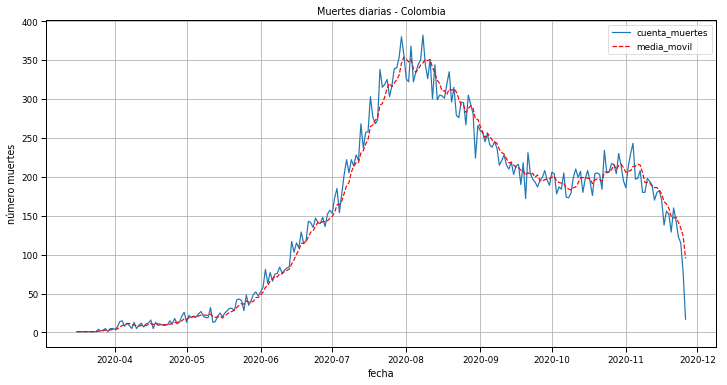

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(muertes_diarias["Fecha de muerte"], muertes_diarias["cuenta_muertes"])
plt.plot(muertes_diarias["Fecha de muerte"], muertes_diarias["media_movil"], "--", c="red")
plt.title("Muertes diarias - Colombia")
plt.xlabel("fecha")
plt.ylabel("número muertes")
plt.legend()
plt.grid()
plt.show()

In [128]:
# ¿dónde se dio el máximo de muertes diarias?
muertes_diarias[muertes_diarias["cuenta_muertes"]==muertes_diarias["cuenta_muertes"].max()]

,Fecha de muerte,cuenta_muertes,media_movil
140,2020-08-08,382,346.4


Las muertes llegaron a un pico al rededor del mes de Agosto, cuyo máximo fue de 382 muertes reportadas en un solo día, el día 8 de Agosto.  

El comportamiento de las muertes parece ser muy estable desde la caída de la ola de agosto, y, al contrario de la serie de infecciones diarias, la de muertes no parece estar atravesando una segunda ola aún.

### Tasa de letalidad: relación entre muertes y casos diarios

La tasa de letalidad es la relación entre el número de muertos y el número de infectados (conocidos)  
Es de interés conocer qué tan alta es la tasa de letalidad para los datos reportados en colombia.

In [129]:
casos_muertes_df = casos_diarios.merge(muertes_diarias, left_on="Fecha de notificación", right_on="Fecha de muerte")

# cálculo de la tasa de letalidad
casos_muertes_df["tasa_letalidad"] = casos_muertes_df["cuenta_muertes"]/casos_muertes_df["cuenta_casos"]

In [130]:
window = 14 # tamaño de la ventana para la media móvil
casos_muertes_df[f'media_movil_tasa_letalidad'] = casos_muertes_df["tasa_letalidad"].rolling(window, min_periods=1).mean()

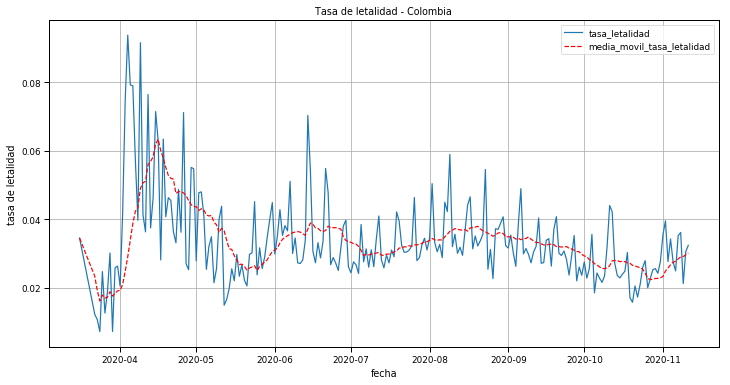

In [131]:
plt.figure(figsize=(12, 6))
plt.plot(casos_muertes_df["Fecha de notificación"], casos_muertes_df["tasa_letalidad"])
plt.plot(casos_muertes_df["Fecha de notificación"], casos_muertes_df["media_movil_tasa_letalidad"], "--", c="red")
plt.title("Tasa de letalidad - Colombia")
plt.xlabel("fecha")
plt.ylabel("tasa de letalidad")
plt.legend()
plt.grid()
plt.show()

La tasa de letalidad parece haber sido mayor en los primeros meses de pandemia. Luego tiende a converger a un valor y permanecer estable. 

La causa de esto no se puede determinar con 100% de precisión, pero las hipótesis planteadas para esto son:
1. Al principio era más probable morir por la enfermedad debido a que los servicios médicos no estaban preparados (tanto en procedimientos como en infraestructura) para enfrentar los casos. 

2. Es posible que hubiera un sub-registro de casos. Al principio de la pandemia Colombia estaba muy limitada en la cantidad de pruebas que podía hacer al día. Esto implicaría que el porcentaje de casos conocidos era menor, por lo tanto, así muera la misma gente, el numerador es más pequeño, haciendo que la razón muertes/conocidos se haga más grande

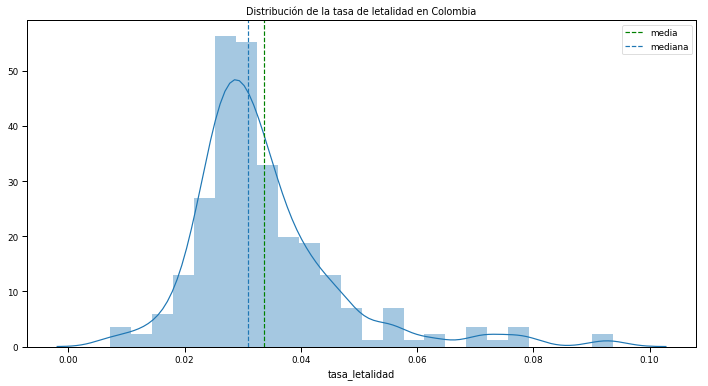

count    236.000000
mean       0.033687
std        0.012996
min        0.007143
25%        0.026122
50%        0.030853
75%        0.037572
max        0.093750
Name: tasa_letalidad, dtype: float64

In [132]:
plt.figure(figsize=(12, 6))
sns.distplot(casos_muertes_df.tasa_letalidad)
plt.title("Distribución de la tasa de letalidad en Colombia")
plt.axvline(np.mean(casos_muertes_df.tasa_letalidad), linestyle = "--", label="media", color="g")
plt.axvline(np.median(casos_muertes_df.tasa_letalidad), linestyle = "--", label="mediana")
plt.legend()
plt.show()

casos_muertes_df.tasa_letalidad.describe()

La tasa de letalidad tiene una media de 3.3% y una esviación de aproximadamente. 
Esto quiere decir, que a números gruesos, la probabilidad de que alguien infecado se muera es del 3.3%  
La media en este caso se ve afectada dada una cola derecha de la distribución. Esta cola es generada por los valores altos de letalidad que tuvo la infección durante los primeros meses

Cabe aclarar que esto es una estadística gruesa aplicada a Colombia. 
Se conoce que hay otros factores asociados al riesgo de fallecer por coronavirus como lo son:  
* Grupo etario
* Comorbilidades: hipertensión, obesidad, asma, enfermedades auto-inmunes, diabetes, problemas cardio-respiratorios. 

Incluso, el hecho de disponibildiad y calidad de los servicios de salud son determinantes en el proceso de recuperación de las personas

Por lo cual, si eres una persona en colombia tienes una probabilidad gruesa de morir por coronavirus del 3.3%, pero si perteneces por ejemplo a poblaciones de riesgo, este porcentaje crecerá y a su vez, si no tienes factores de riesgo en tu contra, este porcentaje será menor

Relación entre el número de casos y el número de muertes


<Figure size 864x432 with 0 Axes>

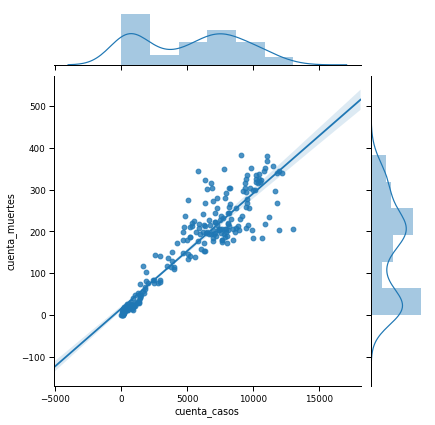

In [133]:
print("Relación entre el número de casos y el número de muertes")
plt.figure(figsize=(12, 6))
sns.jointplot(x="cuenta_casos", y="cuenta_muertes", data=casos_muertes_df, kind="reg")
plt.show()

Se comprueba que hay una relación entre el número de casos y el número de muertes.  
Esto era esperable pues hemos visto cómo la tasa de letalidad parece converger a un número (cerca del 3%)

Por este motivo, es esperable también que el número de muertes por región tenga un comportamiento proporcional al número de casos por región, como se verá en el siguiente gráfico

### Distribución geográfica de los casos fallecidos

In [134]:
bd_fallecidos = bd[bd["Estado"]=="fallecido"]
# bd_fallecidos.shape

In [135]:
dpto_muertes = bd_fallecidos.groupby(["Código DIVIPOLA departamento", "Nombre departamento"])["ID de caso"].count().reset_index()
dpto_muertes = dpto_muertes.rename(columns={"ID de caso":"cuenta_muertes"})
dpto_data.head()

,Código DIVIPOLA departamento,Nombre departamento,cuenta_casos
0,05,ANTIOQUIA,197994
1,08,ATLANTICO,32108
2,11,BOGOTA,347316
3,13,BOLIVAR,7005
4,13001,CARTAGENA,28935


In [136]:
# gráfica del mapa de colombia, dando un color de acuerdo al número de casos de muertes por departamento
fig = px.choropleth(
        dpto_muertes,
        locations='Código DIVIPOLA departamento',
        geojson=geodata_dpto,
        featureidkey="properties.DPTO_CCDGO",
        projection='mercator',
        color='cuenta_muertes',
        color_continuous_scale= ["#B2F121", "red"],
        hover_data=['Nombre departamento', 'cuenta_muertes'],
        height=500
        )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

Como era de esperarse, este mapa es muy similar al mapa que vimos en la sección de distribución geográfica de los casos. Lo único que cambia es la escala. 

  
Sin embargo, hay un análisis interesante por hacer, y es mirar la tasa de letalidad por departamento. Esto permitirá conocer si hay regiones donde la gente sea más propensa a complicarse.

### Distribución geográfica de la tasa de letalidad

In [137]:
# completamos el dataframe dpto_data que definimos antes
# se le agregará la columna de "cuenta_muertes"
dpto_data = dpto_data.merge(dpto_muertes[["Nombre departamento", "cuenta_muertes"]])

# se calcula la tasa de letalidad por departamento
dpto_data["tasa_letalidad"] = dpto_data["cuenta_muertes"]/dpto_data["cuenta_casos"]
dpto_data.head()

,Código DIVIPOLA departamento,Nombre departamento,cuenta_casos,cuenta_muertes,tasa_letalidad
0,05,ANTIOQUIA,197994,3887,0.019632
1,08,ATLANTICO,32108,1446,0.045036
2,11,BOGOTA,347316,8305,0.023912
3,13,BOLIVAR,7005,271,0.038687
4,13001,CARTAGENA,28935,622,0.021496


In [138]:
# gráfica del mapa de colombia, dando un color de acuerdo a la tasa de letalidad por departamento
fig = px.choropleth(
        dpto_data,
        locations='Código DIVIPOLA departamento',
        geojson=geodata_dpto,
        featureidkey="properties.DPTO_CCDGO",
        projection='mercator',
        color='tasa_letalidad',
        color_continuous_scale= ["#B2F121", "red"],
        hover_data=['Nombre departamento', 'tasa_letalidad'],
        height=500
        )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

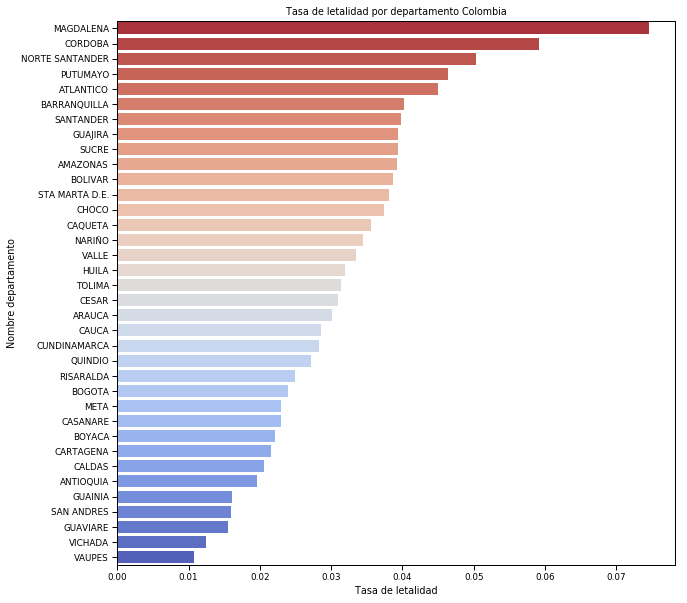

In [139]:
# gráfico de barras
plt.figure(figsize=(10, 10))
sns.set_context('paper')
sns.barplot(x="tasa_letalidad",y="Nombre departamento", data=dpto_data.sort_values(by="tasa_letalidad", ascending=False), palette="coolwarm_r")
plt.title("Tasa de letalidad por departamento Colombia")
plt.xlabel("Tasa de letalidad")
plt.show()

Acá hay un hallazgo interesante y es que en efecto, la tasa de letalidad no es similar por regiones. 

Nótese cuán distinto es este mapa respecto a los mapas de distribución de casos y muertes. 

En esta nueva versión ya los protagonistas no son **Bogotá**, **Antioquia** y **Valle**, sino que el papel principal pasó a:
* Magdalena
* Córdoba
* Norte de Santander
* Putumayo
* Atlántico

Encontrar el por qué de esta relación, va más allá de nuestro alcance en este trabajo, pero se pueden plantear hipótesis en términos de la disponibilidad y calidad de los servicios de salud en estas regiones.  
En Colombia, las ciudades principales cuentan con más cobertura en servicios de salud.

Cabe señalar que esto no es más que una hipótesis que debe ser contrastada con datos de servicios de salud en Colombia para ser verificada, pero como se mencionó antes, va más allá del alcance de este trabajo.

## Modelo predictivo

Son ya bien conocidos, cantidades de modelos para predecir el número de contagiados/muertos en el tiempo. 

Técnicas supervisadas como:
* Regresión 
* Series temporales
* redes neuronales
son muy comunes para estimar estas variables. 

También técnicas epidemiológicas han sido utilizadas (con menor desempeño):
* Modelos SIR (Susceptibles, Infectados, Recuperados/Muertos)
* SEIR (el mismo SIR pero con un estado de Expuesto)

Pero los resultados de estos modelos no han ajustado del todo bien a la pandemia, y son modelos que normalmente no son generalizables o útiles en regiones distintas. Esto debido a que las medidas de los distintos países pueden ser diferentes, además las adopciones de esas medidas son muy distintas dependiendo de la cultura.


Por estos motivos plantearé un enfoque distinto:  

* Qué tal si en vez de predecir **_¿cuántos habrá?_**, intentamos predecir: **_¿qué pasa cuando se infecte?_**

Un modelo de esta índole puede servir para gestionar los recursos limitados.  
Si conoces de antemano la probabilidad de que alguien fallezca, podrías actuar de manera proactiva y priorizar los recursos en quienes más los necesiten

### Especificación del problema

En Esta sección se modelará un problema de **Clasificación**

Se utilizarán variables disponibles en el dataset de covid para estimar la probabilidad de que un caso:
* 0: Se recupera
* 1: Fallece

### Datos a utilizar
Se utilizará la información "personal" de cada caso. Sería de gran utilidad para el desempeño de este modelo si se contara con información como comorbilidades, pero no es el caso.

Para este trabajo se realizará una modelación simple con solo 3 variables explicativas:
* Nombre departamento
* Sexo
* grupo_etario

In [140]:
# la variable objetivo tendrá el valor de 1 si el caso es de fallecido. 0 de otro modo.
target = (bd["Estado"] == "fallecido") + 0.0

In [141]:
# lista de variables que deberán pasar por un one hot encoding
lista2onehot = ['Nombre departamento', 'Sexo', 'grupo_etario']
dataset = bd[lista2onehot+["Edad"]]
dataset.head()

,Nombre departamento,Sexo,grupo_etario,Edad
0,BOGOTA,F,"(10, 20]",19
1,VALLE,M,"(30, 40]",34
2,ANTIOQUIA,F,"(40, 50]",50
3,ANTIOQUIA,M,"(50, 60]",55
4,ANTIOQUIA,M,"(20, 30]",25


### Preparación de los datos para ejecutar el entrenamiento

Como trabajaremos con 3 variables categóricas, emplearemos la técnica de "one hot encoding" que nos permitirá volver numéricas las categorías y así usarlas dentro del modelo

In [142]:
# la siguiente función fue escrita por mí, pero en otro proyecto así que sus comentarios están en inglés
def onehotencode_list_of_variables(df, variables, delete_original=False, verbose=False):
    # this function gets a df and a variable list and returns
    # the same df but instead of the columns with variables in "variable"
    # it will contain the onehot vector for those variables
    # params:
    #   df: the dataframe that contains a categorical column "variable"
    #   variables: the list of the variable to onehot encode
    #   delete_original: boolean value to indicate if delete the column
    #   variable. If True it will get rid of the original variable
    
    for var in variables:
        df_dummies = pd.get_dummies(df[var], prefix="onehot_"+var)
        df = pd.concat([df, df_dummies], axis=1)
        if verbose:
            print(var, df.shape)
    
    # get rid of the original variable
    if delete_original:
        df = df.drop(variables, axis=1)
    return df

In [143]:
# Crear train_data (estructura para entrenar)
train_data = onehotencode_list_of_variables(dataset, lista2onehot, True, True)

Nombre departamento (1221170, 40)
Sexo (1221170, 42)
grupo_etario (1221170, 50)


Esta técnica convierte cada categoría en una variable. Así por ejemplo la variable sexo la toma y crea 2 columnas: 
* Sexo_F
* Sexo_M  

De esta forma todos los datos que tenían "M" en la columna "Sexo", ahora tendrán un 1 en la columna "Sexo_M" y un 0 en la columna "Sexo_F"  
Esta misma metodología aplica para cada una de las categorías de las variables "Nombre departamento" y "grupo_etario"

Ahora nos queda una base de datos con 50 variables explicativas

### Determinación de las matrices X e y
En este caso encontraremos un vector b, minimice el error de la siguiente ecuación: 

$$ X \times b^t = y$$

Donde:
* X será la matriz de características de tamaño mxn, donde m es el número de instancias y n es el numero de variables (50 en nuestro caso)
* y será el vector de variable objetivo, de tamaño m (el número de instancias)
* b será el vector de parámetros óptimos para minimizar el error de esta ecuación

In [144]:
X = train_data
print(X.shape)
y = target
print(y.shape)

(1221170, 47)
(1221170,)


### Partir los datos
Para garantizar que el modelo entrenado generalice suficientemente bien el fenómeno, es necesario guardar una porción de los datos para validar la calidad de las predicciones. 

* Se utilizará un 80% de los datos para entrenar, es decir, el modelo verá los ejemplos de este 80% y ajustará sus parámetros para minimizar su error

* Se utilizará un 20% de los datos para validar, es decir, el modelo nunca verá estos datos durante el proceso de entrenamiento y una vez haya terminado esta etapa, le pediremos predecir sobre el conjunto de validación.  
Conocemos las respuestas de este conjunto, pero el modelo no, así que la métrica sobre este conjunto es la estimación de qué tan bien generaliza el modelo

In [145]:
# Splitting the dataset into the Training set and Val set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("tamaño del training set:", X_train.shape)
print("tamaño del validation set:", X_val.shape)

tamaño del training set: (976936, 47)
tamaño del validation set: (244234, 47)


#### Logistric regression
Se utilizará un modelo de regresión logística, pues es el más simple de los modelos lineales para problemas de clasificación.  

A grandes rasgos este modelo dará un peso a cada varible y realizará el producto punto entre los pesos y las variables para realizar la predicción.

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()#(class_weight="balanced")
logreg.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

### Evaluación del modelo

Evaluemos qué tan bien ajustó el modelo a los datos. 

Es comun utilizar una métrica de precisión para evaluar los modelos de clasificación, pero en nuestro caso, esta métrica no serviría pues como vimos antes, un 3% de los datos son muertes y el otro 97% no lo son. 

Esto quiere decir que nuestras clases no están balanceadas y un clasificador que siempre entregue "0" ya estaría prediciendo correctamente el 97% de los datos. 

Por estos motivos, la métrica más común es el área bajo la curva ROC. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [147]:
print("making predictions")
y_train_pred = logreg.predict_proba(X_train)[:, 1]
y_val_pred = logreg.predict_proba(X_val)[:, 1]

print("printing metrics")
train_roc_score = roc_auc_score(y_train, y_train_pred)
val_roc_score = roc_auc_score(y_val, y_val_pred)
print("train_roc:", train_roc_score)
print("val_roc:", val_roc_score)

making predictions
printing metrics
train_roc: 0.9052997022040304
val_roc: 0.902666082882325


tanto el conjunto de __entrenamiento__ como el conjunto de __validación__ obtuvieron un ROC_AUC de _0.90_

Esto es una gran noticia para un modelo pues:
* un valor de 0.9 implica que el modelo está teniendo un desempeño excelente (en la industria, hasta un 0.7 se considera bueno)
* que ambos conjuntos tengan un ROC_AUC parecido, significa que no hubo sobre entrenamiento, es decir, que el modelo está generalizando bien el fenómeno

In [148]:
# Métricas estadísticas interesantes
from sklearn.metrics import classification_report
print(classification_report(y_val, np.round(y_val_pred, 0)))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    237094
         1.0       0.48      0.02      0.03      7140

    accuracy                           0.97    244234
   macro avg       0.72      0.51      0.51    244234
weighted avg       0.96      0.97      0.96    244234



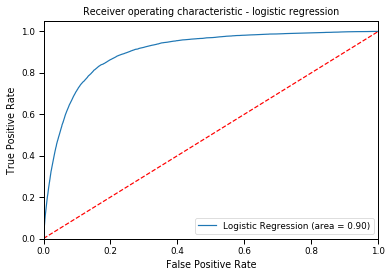

In [149]:
# Gráfica de la curva roc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_val, y_val_pred)
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - logistic regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Punto de corte óptimo
En muchas ocasiones la probabilidad nos será suficiente, pero en algunos ámbitos será necesario dar un veredicto final. 

Por ejemplo en este caso podríamos separar de manera dura las dos clases. 

Para esto debemos fijar un punto de corte a la probabilidad. Así los casos que tengan menor probabilidad que ese punto de corte se clasificarán como __0__ y los que superen el punto de corte se clasificarán como __1__.

El punto de corte se suele dejar en 0.5, pero si quisiéramos ser más rigurosos, podemos optimizar este valor

In [150]:
def find_Optimal_Cutoff(target, predicted):
    # Esta función recibe el vector target con las respuestas
    # y recibe el vector "predicted" con las predicciones
    # y calculará el punto óptimo en términos de que iguala la especificidad y la sensibilidad
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [151]:
optimal_cutoff = find_Optimal_Cutoff(y_val, y_val_pred)[0]
optimal_cutoff

0.034567755384936116

In [152]:
# la siguiente función fue tomada de: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="Green" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[197766  39328]
 [  1198   5942]]


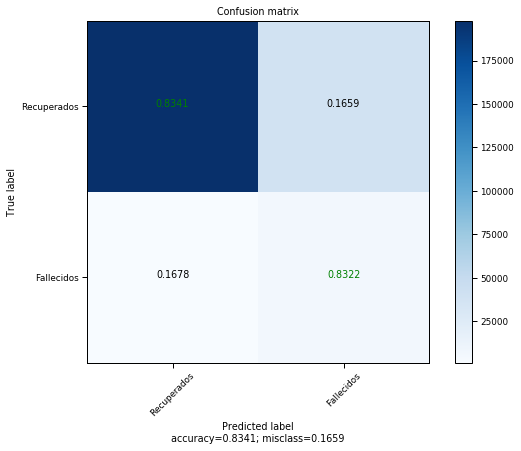

In [153]:
cm =confusion_matrix(y_val, y_val_pred>optimal_cutoff)
print(cm)
plot_confusion_matrix(cm, target_names=["Recuperados", "Fallecidos"])

Como se puede observar en la matriz de confusión, el modelo predijo correctamente al 83% de los casos __Recuperados__  
y predijo también correctamente al 83% de los casos __Fallecidos__

El hecho de que predijera igual de bien ambas clases no es casualidad. Es debido a que buscamos un punto óptimo en las probabilidades que justamente hiciera eso, es decir que penalice falsos positivos y falsos negativos por igual.

In [154]:
# sensitivity
sensitivity = cm[1][1]/(cm[1][0]+cm[1][1])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])

print("sensitivity:", sensitivity)
print("specificity:", specificity)

sensitivity: 0.8322128851540617
specificity: 0.834124861869132


## Conclusiones

En este trabajo se encontraron hallazgos interesantes como por ejemplo:
* Los hombres se complican más que las mujeres y
* La tasa de letalidad no es uniforme a través de las regiones

Se logró entrenar un modelo sencillo como la regresión lineal y se obtuvo un muy buen desempeño de este con un 0.9 de ROC_AUC sobre los datos de validación y además este no presentó sobre ajuste.  
Esto nos indica que las variables relacionadas con Edad, Departamento (Región) y sexo, son muy buenos estimadores del riesgo de fallecer por covid 19 en Colombia.